# CodeCLIP Experiment Notebook

**Objective:** Configuration-driven contrastive learning analysis of code generation quality across different models and labeling schemes.

**Experiments:**
- **Model**: Multi-class classification (gpt, codellama, llama3.1, human)
- **Target**: Binary classification (human vs AI)

**Key Steps:**
1. Load and sample Python code dataset (CoDET-M4)
2. Parse code to Abstract Syntax Tree (AST)
3. Convert AST to PyTorch Geometric graphs
4. Encode graph and text features using pre-trained models
5. Train CodeCLIP model with contrastive learning
6. Extract embeddings and analyze results

## 1. Configuration & Parameters

In [1]:
# Experiment Configurations
experiments_config = [
    {'label_field': 'model', 'description': 'Multi-class: gpt, codellama, llama3.1, human'},
    {'label_field': 'target', 'description': 'Binary: human, ai'}
]

# Global parameters (shared across experiments)
checkpoint_base_dir = 'checkpoints/CodeCLIP'
num_epochs = 100
batch_size = 128
embedding_dim = 256
learning_rate = 1e-3
graph_in_dim = 384
seed = 42
skip_training_if_exists = False

# Storage for results
experiment_results = {}

In [ ]:
def validate_config():
    """Validate configuration parameters before execution."""
    assert num_epochs > 0, "num_epochs must be positive"
    assert batch_size > 0, "batch_size must be positive"
    assert 0 < learning_rate < 1, "learning_rate should be between 0 and 1"
    assert embedding_dim > 0, "embedding_dim must be positive"
    print("Configuration validation: PASSED")

validate_config()

## 2. Environment Setup & Dependencies

In [2]:
import subprocess
import sys
import os

# Install all dependencies FIRST before importing anything
print("Installing dependencies...")
subprocess.run([sys.executable, "-m", "pip", "install", "--upgrade", "pip", "setuptools", "wheel", "-q"], capture_output=True)
subprocess.run([sys.executable, "-m", "pip", "install", "-q", "torch_geometric"], capture_output=True)
subprocess.run([sys.executable, "-m", "pip", "install", "-q", "transformers"], capture_output=True)
subprocess.run([sys.executable, "-m", "pip", "install", "-q", "datasets"], capture_output=True)
subprocess.run([sys.executable, "-m", "pip", "install", "-q", "scikit-learn"], capture_output=True)
subprocess.run([sys.executable, "-m", "pip", "install", "-q", "seaborn"], capture_output=True)
subprocess.run([sys.executable, "-m", "pip", "install", "-q", "tqdm"], capture_output=True)

for pkg in ["torch-scatter", "torch-sparse", "torch-cluster"]:
    result = subprocess.run([sys.executable, "-m", "pip", "install", "-q", pkg], capture_output=True, text=True)
    if result.returncode != 0:
        pass

print("Dependencies installed\n")

# NOW import everything
import ast
import random

from datasets import load_dataset
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
import seaborn as sns

import torch
import torch.nn as nn
import torch.optim as optim
import torch_geometric
from torch_geometric.data import Data
from torch_geometric.loader import DataLoader
from torch_geometric.nn import GINEConv, global_mean_pool
from torch_geometric.utils import to_dense_batch

from transformers import AutoTokenizer, AutoModel
from tqdm import tqdm

# Load dataset globally (used in pipeline function)
dataset = load_dataset("DaniilOr/CoDET-M4")
plt.style.use('seaborn-v0_8-darkgrid')

print(f"PyTorch: {torch.__version__}")
print(f"PyG: {torch_geometric.__version__}")
print(f"Device: {'cuda' if torch.cuda.is_available() else 'cpu'}")

Installing dependencies...
✓ Dependencies installed



/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:104: UserWarning: 
Error while fetching `HF_TOKEN` secret value from your vault: 'Requesting secret HF_TOKEN timed out. Secrets can only be fetched when running from the Colab UI.'.
You are not authenticated with the Hugging Face Hub in this notebook.
If the error persists, please let us know by opening an issue on GitHub (https://github.com/huggingface/huggingface_hub/issues/new).
  warnings.warn(


PyTorch: 2.9.0+cu128
PyG: 2.7.0
Device: cuda
✓ All imports ready


In [ ]:
def set_seed(seed_value=42):
    """Set random seeds for reproducibility across all libraries."""
    random.seed(seed_value)
    np.random.seed(seed_value)
    torch.manual_seed(seed_value)
    if torch.cuda.is_available():
        torch.cuda.manual_seed_all(seed_value)

def get_device():
    """Get optimal device for computation."""
    if torch.cuda.is_available():
        device = torch.device('cuda')
        print(f"GPU available: {torch.cuda.get_device_name(0)}")
    else:
        device = torch.device('cpu')
        print("Using CPU")
    return device

set_seed(seed)
DEVICE = get_device()

In [ ]:
def run_codeclip_experiment(label_field_val):
    """
    Complete CodeCLIP pipeline for a given label field.
    Returns dictionary with trained model, embeddings, and metadata.
    """
    label_field = label_field_val
    checkpoint_dir = f'{checkpoint_base_dir}_{label_field}'
    
    # ===== DATA LOADING & SAMPLING =====
    random.seed(seed)
    np.random.seed(seed)
    
    python_dataset_local = dataset['train'].filter(lambda x: x['language'] == 'python')
    print(f"\n[{label_field.upper()}] Loaded {len(python_dataset_local)} Python samples")
    
    # Sample by label
    all_labels_local = [l for l in python_dataset_local[label_field] if l is not None]
    unique_labels_local = sorted(list(set(all_labels_local)))
    print(f"Found {len(unique_labels_local)} labels: {unique_labels_local}")
    
    selected_indices = []
    for label in unique_labels_local:
        label_indices = [i for i, l in enumerate(python_dataset_local[label_field]) if l == label]
        count = min(5, len(label_indices))
        features = random.sample(label_indices, count)
        selected_indices.extend(features)
    
    random.shuffle(selected_indices)
    sample_code_local = python_dataset_local.select(selected_indices)
    print(f"Total samples: {len(sample_code_local)}")
    
    # ===== TEXT TO AST =====
    valid_indices = []
    for idx, example in enumerate(sample_code_local):
        try:
            tree = ast.parse(example['code'])
            valid_indices.append(idx)
        except (SyntaxError, Exception):
            pass
    
    if len(valid_indices) < len(sample_code_local):
        print(f"Filtered out {len(sample_code_local) - len(valid_indices)} invalid examples")
        sample_code_local = sample_code_local.select(valid_indices)
    
    print(f"Valid AST samples: {len(sample_code_local)}")
    
    # ===== AST TO PyG =====
    pyg_dataset_local = []
    for idx, item in enumerate(sample_code_local):
        data = ast_to_pyg_data(item['code'], item[label_field])
        if data:
            pyg_dataset_local.append(data)
    
    print(f"Created {len(pyg_dataset_local)} PyG graphs")
    
    # ===== FEATURE ENCODING =====
    pyg_dataset_local = encode_text_graph(pyg_dataset_local, lm_type="tiny")
    
    if len(pyg_dataset_local) > 0:
        g = pyg_dataset_local[0]
        node_shape = g.x.shape if hasattr(g, 'x') and g.x is not None else 'None'
        edge_shape = g.edge_attr.shape if hasattr(g, 'edge_attr') and g.edge_attr is not None else 'None'
        print(f"Node embeddings: {node_shape} | Edge embeddings: {edge_shape}")
    
    # ===== TRAINING =====
    os.makedirs(checkpoint_dir, exist_ok=True)
    loader = DataLoader(pyg_dataset_local, batch_size=batch_size, shuffle=True)
    
    tokenizer = AutoTokenizer.from_pretrained("sentence-transformers/all-MiniLM-L6-v2")
    vocab_size = tokenizer.vocab_size
    
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    model = Pretrain(graph_in_dim=graph_in_dim, text_vocab_size=vocab_size, embed_dim=embedding_dim).to(device)
    optimizer = optim.Adam(model.parameters(), lr=learning_rate)
    
    checkpoint_path = os.path.join(checkpoint_dir, 'checkpoint.pt')
    
    if os.path.exists(checkpoint_path):
        model.load_state_dict(torch.load(checkpoint_path, map_location=device))
        print(f"Loaded checkpoint from {checkpoint_path}")
        if skip_training_if_exists:
            print("Skipping training")
    
    if not (os.path.exists(checkpoint_path) and skip_training_if_exists):
        model.train()
        for epoch in range(num_epochs):
            total_loss = 0
            for batch_idx, data in enumerate(loader):
                data = data.to(device)
                text_inputs = tokenizer(data.code, padding=True, truncation=True, max_length=512, return_tensors='pt').input_ids.to(device)
                
                optimizer.zero_grad()
                logits_graph, logits_text = model(data, text_inputs)
                loss = model.loss(logits_graph, logits_text)
                loss.backward()
                optimizer.step()
                total_loss += loss.item()
            
            avg_loss = total_loss / len(loader)
            if (epoch + 1) % 10 == 0 or epoch == 0:
                print(f"Epoch {epoch+1}/{num_epochs}, Loss: {avg_loss:.4f}")
            torch.save(model.state_dict(), checkpoint_path)
        print("Training complete")
    
    # ===== EXTRACT EMBEDDINGS =====
    model.eval()
    model.load_state_dict(torch.load(checkpoint_path, map_location=device))
    
    graph_embeddings = []
    with torch.no_grad():
        for batch_idx, data in enumerate(loader):
            data = data.to(device)
            features = model.graph_encoder(data.x, data.edge_index, data.edge_attr, data.batch)
            features = features / features.norm(dim=1, keepdim=True)
            graph_embeddings.append(features.cpu())
    
    all_graph_embeddings = torch.cat(graph_embeddings, dim=0)
    
    # ===== RETURN RESULTS =====
    unique_labels_final = sorted(list(set([data.y for data in pyg_dataset_local])))
    label_counts = {label: sum(1 for d in pyg_dataset_local if d.y == label) for label in unique_labels_final}
    
    return {
        'label_field': label_field,
        'pyg_dataset': pyg_dataset_local,
        'embeddings': all_graph_embeddings,
        'model': model,
        'device': device,
        'checkpoint_path': checkpoint_path,
        'loader': loader,
        'unique_labels': unique_labels_final,
        'label_counts': label_counts,
        'sample_code': sample_code_local
    }


✓ Pipeline function ready


In [ ]:
def ast_to_pyg_data(code_str, target_label):
    """Convert Python code to PyG Data object via AST."""
    try:
        tree = ast.parse(code_str)
    except SyntaxError:
        return None

    node_list = []
    edge_index = [[], []]
    edge_attr = []

    def visit(node, parent_idx=None, relation=None):
        nonlocal node_list, edge_index, edge_attr
        curr_idx = len(node_list)
        node_type = type(node).__name__
        node_list.append({'type': node_type})
        
        if parent_idx is not None:
            edge_index[0].append(parent_idx)
            edge_index[1].append(curr_idx)
            edge_attr.append(relation if relation else "child")
            
        for field, value in ast.iter_fields(node):
            if isinstance(value, list):
                for item in value:
                    if isinstance(item, ast.AST):
                        visit(item, curr_idx, field)
            elif isinstance(value, ast.AST):
                visit(value, curr_idx, field)

    visit(tree)
    if not node_list:
        return None
    
    return Data(
        edge_index=torch.tensor(edge_index, dtype=torch.long),
        num_nodes=len(node_list),
        node_texts=[n['type'] for n in node_list],
        edge_texts=edge_attr,
        code=code_str,
        y=target_label
    )

✓ AST conversion function ready


## 3. Core Functions & Utilities

In [ ]:
def mean_pooling(model_output, attention_mask):
    token_embeddings = model_output[0]
    input_mask_expanded = attention_mask.unsqueeze(-1).expand(token_embeddings.size()).float()
    return torch.sum(token_embeddings * input_mask_expanded, 1) / torch.clamp(input_mask_expanded.sum(1), min=1e-9)

def encode_text_graph(dataset, lm_type="tiny", batch_size=32, device=None):
    device = device or ("cuda" if torch.cuda.is_available() else "cpu")
    
    text_models = {
        "tiny": "sentence-transformers/all-MiniLM-L6-v2",
        "e5": "intfloat/e5-base-v2",
    }
    
    model_id = text_models.get(lm_type, text_models["tiny"])
    print(f"Loading model: {model_id}")
    
    try:
        tokenizer = AutoTokenizer.from_pretrained(model_id)
        model = AutoModel.from_pretrained(model_id).to(device)
    except OSError:
        print(f"Model {model_id} not found. Check connection or model name.")
        return dataset
        
    model.eval()

    def get_embeddings(texts):
        if not texts:
            return None
        all_embs = []
        for i in range(0, len(texts), batch_size):
            batch = texts[i : i + batch_size]
            encoded_input = tokenizer(
                batch, padding=True, truncation=True, 
                max_length=128, return_tensors='pt'
            ).to(device)

            with torch.no_grad():
                model_output = model(**encoded_input)
                sample_embeddings = mean_pooling(model_output, encoded_input['attention_mask'])
            all_embs.append(sample_embeddings.cpu())
        if all_embs:
            return torch.cat(all_embs, dim=0)
        return None

    print(f"Encoding features for {len(dataset)} graphs...")
    for i, data in enumerate(tqdm(dataset)):
        if hasattr(data, 'node_texts') and data.node_texts:
            data.x = get_embeddings(data.node_texts)
        if hasattr(data, 'edge_texts') and data.edge_texts:
            data.edge_attr = get_embeddings(data.edge_texts)
    return dataset

✓ Encoding functions ready


In [ ]:
class GraphEncoder(nn.Module):
    def __init__(self, in_dim=384, hidden_dim=256, out_dim=256, num_layers=2):
        super(GraphEncoder, self).__init__()
        self.node_proj = nn.Linear(in_dim, hidden_dim)
        self.edge_proj = nn.Linear(in_dim, hidden_dim)
        self.convs = nn.ModuleList()
        
        for _ in range(num_layers):
            mlp = nn.Sequential(
                nn.Linear(hidden_dim, hidden_dim), 
                nn.ReLU(), 
                nn.Linear(hidden_dim, hidden_dim)
            )
            self.convs.append(GINEConv(mlp, train_eps=True))
            
        self.out_proj = nn.Linear(hidden_dim, out_dim)
        self.alpha = nn.Parameter(torch.tensor(1.0))

    def forward(self, x, edge_index, edge_attr, batch=None):
        if batch is None:
            batch = torch.zeros(x.size(0), dtype=torch.long, device=x.device)

        h = self.node_proj(x)
        e = self.edge_proj(edge_attr)
        
        for conv in self.convs:
            x = conv(h, edge_index, e) + h
            h = torch.relu(x)
            
        h_mean = global_mean_pool(h, batch)
        h_dense, _ = to_dense_batch(h, batch)
        h_root = h_dense[:, 0, :] 
        out = h_mean + self.alpha * h_root
        
        return self.out_proj(out)


class TextEncoder(nn.Module):
    def __init__(self, vocab_size=30522, embed_dim=256, num_heads=4, num_layers=2, max_len=512):
        super(TextEncoder, self).__init__()
        self.embedding = nn.Embedding(vocab_size, embed_dim)
        self.pos_encoder = nn.Parameter(torch.randn(1, max_len, embed_dim))
        
        encoder_layer = nn.TransformerEncoderLayer(d_model=embed_dim, nhead=num_heads, batch_first=True)
        self.transformer = nn.TransformerEncoder(encoder_layer, num_layers=num_layers)
        
    def forward(self, x):
        x_emb = self.embedding(x)
        seq_len = x.shape[1]
        x_emb = x_emb + self.pos_encoder[:, :seq_len, :]
        x_out = self.transformer(x_emb)
        return x_out.mean(dim=1)


class Pretrain(nn.Module):
    def __init__(self, graph_in_dim=384, text_vocab_size=30522, embed_dim=256):
        super(Pretrain, self).__init__()
        self.graph_encoder = GraphEncoder(in_dim=graph_in_dim, hidden_dim=embed_dim, out_dim=embed_dim)
        self.text_encoder = TextEncoder(vocab_size=text_vocab_size, embed_dim=embed_dim)
        self.logit_scale = nn.Parameter(torch.ones([]) * 0.07)
        
    def forward(self, graph_batch, text_input):
        graph_features = self.graph_encoder(graph_batch.x, graph_batch.edge_index, graph_batch.edge_attr, graph_batch.batch)
        text_features = self.text_encoder(text_input)
        
        graph_features = graph_features / graph_features.norm(dim=1, keepdim=True)
        text_features = text_features / text_features.norm(dim=1, keepdim=True)
        
        logit_scale = self.logit_scale.exp()
        logits_per_graph = logit_scale * graph_features @ text_features.t()
        logits_per_text = logits_per_graph.t()
        
        return logits_per_graph, logits_per_text
        
    def loss(self, logits_per_graph, logits_per_text):
        batch_size = logits_per_graph.shape[0]
        labels = torch.arange(batch_size, device=logits_per_graph.device)
        loss_graph = nn.functional.cross_entropy(logits_per_graph, labels)
        loss_text = nn.functional.cross_entropy(logits_per_text, labels)
        return (loss_graph + loss_text) / 2


class Downstream(nn.Module):
    def __init__(self, pretrained_model, embed_dim=256, num_classes=2, hidden_dim=128):
        super(Downstream, self).__init__()
        self.graph_encoder = pretrained_model.graph_encoder
        for param in self.graph_encoder.parameters():
            param.requires_grad = False
        self.classifier = nn.Sequential(
            nn.Linear(embed_dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, num_classes)
        )
        
    def forward(self, graph_batch):
        features = self.graph_encoder(graph_batch.x, graph_batch.edge_index, graph_batch.edge_attr, graph_batch.batch)
        return self.classifier(features)

✓ CodeCLIP models loaded


In [ ]:
print("="*70)
print("RUNNING CodeCLIP EXPERIMENTS")
print("="*70)

for config in experiments_config:
    label_field_val = config['label_field']
    print(f"\n{'─'*70}")
    print(f"Experiment: {label_field_val.upper()} - {config['description']}")
    print(f"{'─'*70}")
    
    result = run_codeclip_experiment(label_field_val)
    experiment_results[label_field_val] = result

print("="*70)
print("Experiments completed")
print("="*70)

RUNNING CodeCLIP EXPERIMENTS

──────────────────────────────────────────────────────────────────────
Experiment: MODEL - Multi-class: gpt, codellama, llama3.1, human
──────────────────────────────────────────────────────────────────────

[MODEL] Loaded 185163 Python samples
Found 6 labels: ['codellama', 'gpt', 'human', 'llama3.1', 'nxcode', 'qwen1.5']
Total samples: 30
Filtered out 1 invalid examples
Valid AST samples: 29
Created 29 PyG graphs
Loading model: sentence-transformers/all-MiniLM-L6-v2


Loading weights:   0%|          | 0/103 [00:00<?, ?it/s]

BertModel LOAD REPORT from: sentence-transformers/all-MiniLM-L6-v2
Key                     | Status     |  | 
------------------------+------------+--+-
embeddings.position_ids | UNEXPECTED |  | 

Notes:
- UNEXPECTED	:can be ignored when loading from different task/architecture; not ok if you expect identical arch.


Encoding features for 29 graphs...


100%|██████████| 29/29 [00:01<00:00, 20.41it/s]


Node embeddings: torch.Size([63, 384]) | Edge embeddings: torch.Size([62, 384])
Loaded checkpoint from checkpoints/CodeCLIP_model/checkpoint.pt
Epoch 1/100, Loss: 2.4085
Epoch 10/100, Loss: 2.5115
Epoch 20/100, Loss: 2.4551
Epoch 30/100, Loss: 2.4062
Epoch 40/100, Loss: 2.3889
Epoch 50/100, Loss: 2.3733
Epoch 60/100, Loss: 2.3594
Epoch 70/100, Loss: 2.3480
Epoch 80/100, Loss: 2.3344
Epoch 90/100, Loss: 2.3056
Epoch 100/100, Loss: 2.2973
Training complete
Extracted embeddings: torch.Size([29, 256])
✓ Completed model experiment


──────────────────────────────────────────────────────────────────────
Experiment: TARGET - Binary: human, ai
──────────────────────────────────────────────────────────────────────

[TARGET] Loaded 185163 Python samples
Found 2 labels: ['ai', 'human']
Total samples: 10
Filtered out 3 invalid examples
Valid AST samples: 7
Created 7 PyG graphs
Loading model: sentence-transformers/all-MiniLM-L6-v2


Loading weights:   0%|          | 0/103 [00:00<?, ?it/s]

BertModel LOAD REPORT from: sentence-transformers/all-MiniLM-L6-v2
Key                     | Status     |  | 
------------------------+------------+--+-
embeddings.position_ids | UNEXPECTED |  | 

Notes:
- UNEXPECTED	:can be ignored when loading from different task/architecture; not ok if you expect identical arch.


Encoding features for 7 graphs...


100%|██████████| 7/7 [00:00<00:00,  7.87it/s]


Node embeddings: torch.Size([138, 384]) | Edge embeddings: torch.Size([137, 384])
Loaded checkpoint from checkpoints/CodeCLIP_target/checkpoint.pt
Epoch 1/100, Loss: 1.0837
Epoch 10/100, Loss: 1.1141
Epoch 20/100, Loss: 1.0656
Epoch 30/100, Loss: 1.0033
Epoch 40/100, Loss: 0.9696
Epoch 50/100, Loss: 0.9561
Epoch 60/100, Loss: 0.9425
Epoch 70/100, Loss: 0.9325
Epoch 80/100, Loss: 0.9244
Epoch 90/100, Loss: 0.9152
Epoch 100/100, Loss: 0.9065
Training complete
Extracted embeddings: torch.Size([7, 256])
✓ Completed target experiment

ALL EXPERIMENTS COMPLETED


In [ ]:
def create_experiment_log():
    """Create detailed experiment log for reproducibility."""
    log = {
        'timestamp': pd.Timestamp.now(),
        'seed': seed,
        'device': str(DEVICE),
        'configuration': {
            'epochs': num_epochs,
            'batch_size': batch_size,
            'learning_rate': learning_rate,
            'embedding_dim': embedding_dim,
            'graph_input_dim': graph_in_dim
        },
        'experiments': experiments_config
    }
    return log

experiment_log = create_experiment_log()
print(f"Experiment started at {experiment_log['timestamp']}")

## 4. Model Architecture & Components

## 5. Execute Experiments

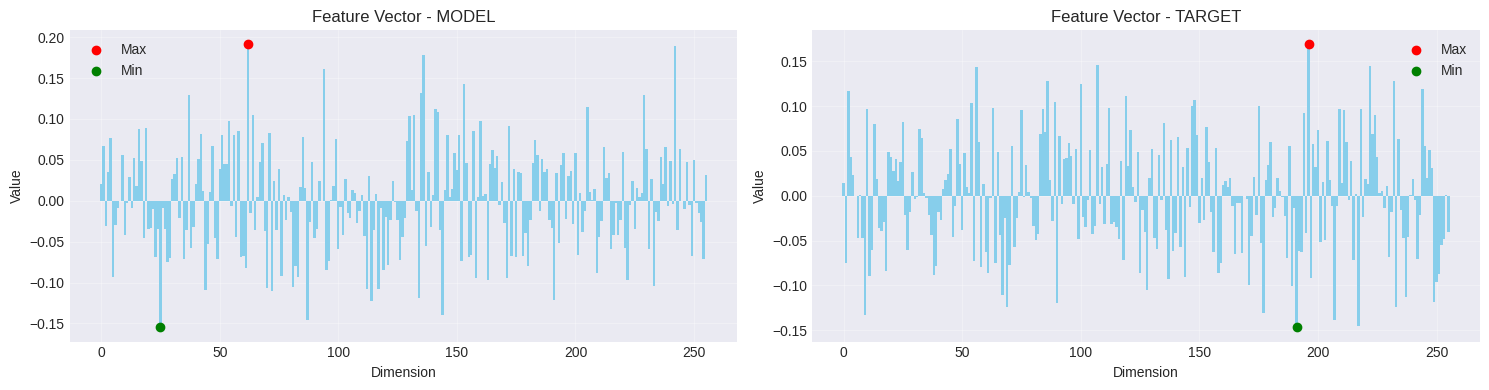

In [11]:
fig, axes = plt.subplots(1, len(experiment_results), figsize=(15, 4))
if len(experiment_results) == 1:
    axes = [axes]

for idx, (label_field_val, results) in enumerate(experiment_results.items()):
    embedding_vector = results['embeddings'][0, :].numpy()
    
    axes[idx].bar(range(len(embedding_vector)), embedding_vector, color='skyblue', width=1.0)
    axes[idx].set_title(f'Feature Vector - {label_field_val.upper()}')
    axes[idx].set_xlabel('Dimension')
    axes[idx].set_ylabel('Value')
    axes[idx].grid(True, alpha=0.3)
    
    max_idx = np.argmax(embedding_vector)
    min_idx = np.argmin(embedding_vector)
    axes[idx].scatter([max_idx], [embedding_vector[max_idx]], color='red', label='Max', zorder=5)
    axes[idx].scatter([min_idx], [embedding_vector[min_idx]], color='green', label='Min', zorder=5)
    axes[idx].legend()

plt.tight_layout()
plt.show()

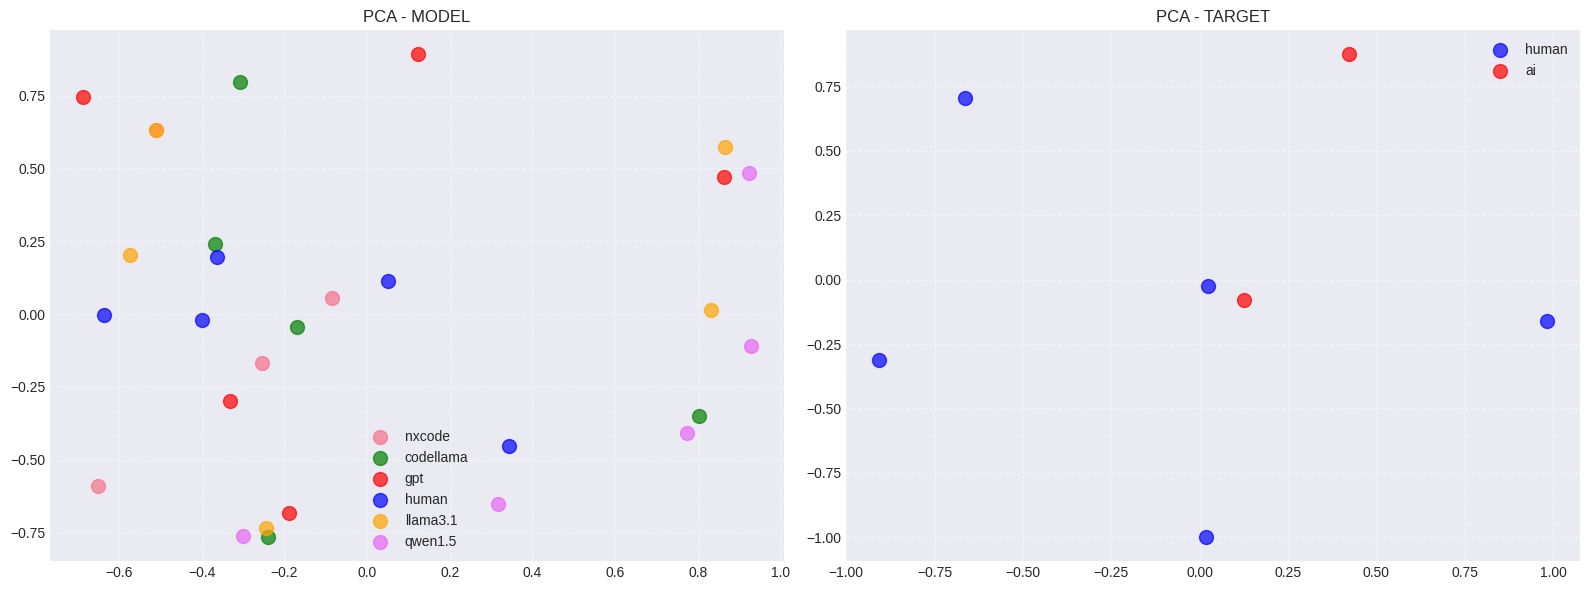

In [12]:
fig, axes = plt.subplots(1, len(experiment_results), figsize=(16, 6))
if len(experiment_results) == 1:
    axes = [axes]

color_map = {
    'human': 'blue', 'gpt': 'red', 'gpt4o': 'darkred',
    'llama3.1': 'orange', 'codellama': 'green', 'ai': 'red'
}

for idx, (label_field_val, results) in enumerate(experiment_results.items()):
    embeddings = results['embeddings'].detach().cpu().numpy()
    labels = [data.y for data in results['pyg_dataset']]
    
    pca = PCA(n_components=2)
    embeddings_2d = pca.fit_transform(embeddings)
    
    label_set = list(set(labels))
    fallback_colors = sns.color_palette("husl", len(label_set))
    
    for i, label in enumerate(label_set):
        indices = [j for j, l in enumerate(labels) if l == label]
        if indices:
            color = color_map.get(label, fallback_colors[i])
            axes[idx].scatter(embeddings_2d[indices, 0], embeddings_2d[indices, 1],
                            c=[color], label=label, alpha=0.7, s=100)
    
    axes[idx].set_title(f'PCA - {label_field_val.upper()}')
    axes[idx].legend()
    axes[idx].grid(True, linestyle='--', alpha=0.5)

plt.tight_layout()
plt.show()

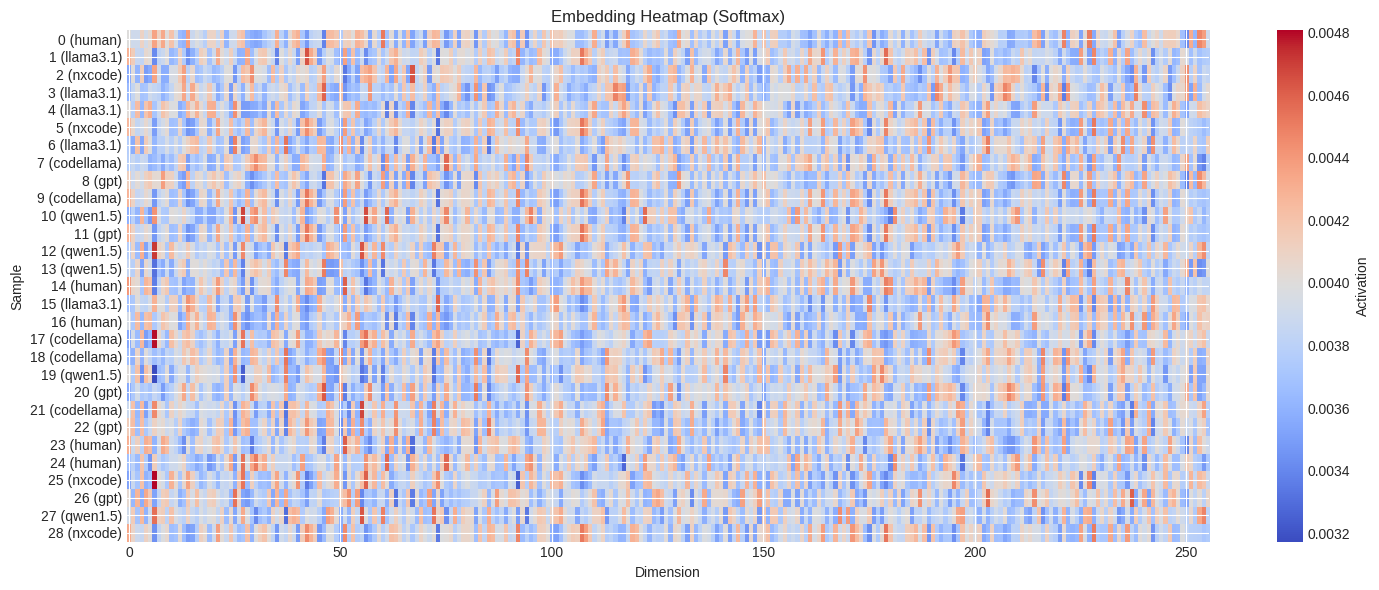

In [ ]:
for label_field_val, results in experiment_results.items():
    embeddings = results['embeddings'].detach().cpu().numpy()
    embeddings_exp = np.exp(embeddings - np.max(embeddings, axis=1, keepdims=True))
    embeddings_exp = embeddings_exp / np.sum(embeddings_exp, axis=1, keepdims=True)
    
    plt.figure(figsize=(15, 6))
    img = plt.imshow(embeddings_exp, cmap='coolwarm', aspect='auto', interpolation='nearest')
    plt.colorbar(img, label='Activation')
    plt.title(f'Embedding Heatmap (Softmax) - {label_field_val.upper()}')
    plt.xlabel('Dimension')
    plt.ylabel('Sample')
    labels_viz = [data.y for data in results['pyg_dataset']]
    plt.yticks(range(len(embeddings)), labels=[f"{i} ({l})" for i, l in enumerate(labels_viz)])
    plt.tight_layout()
    plt.show()

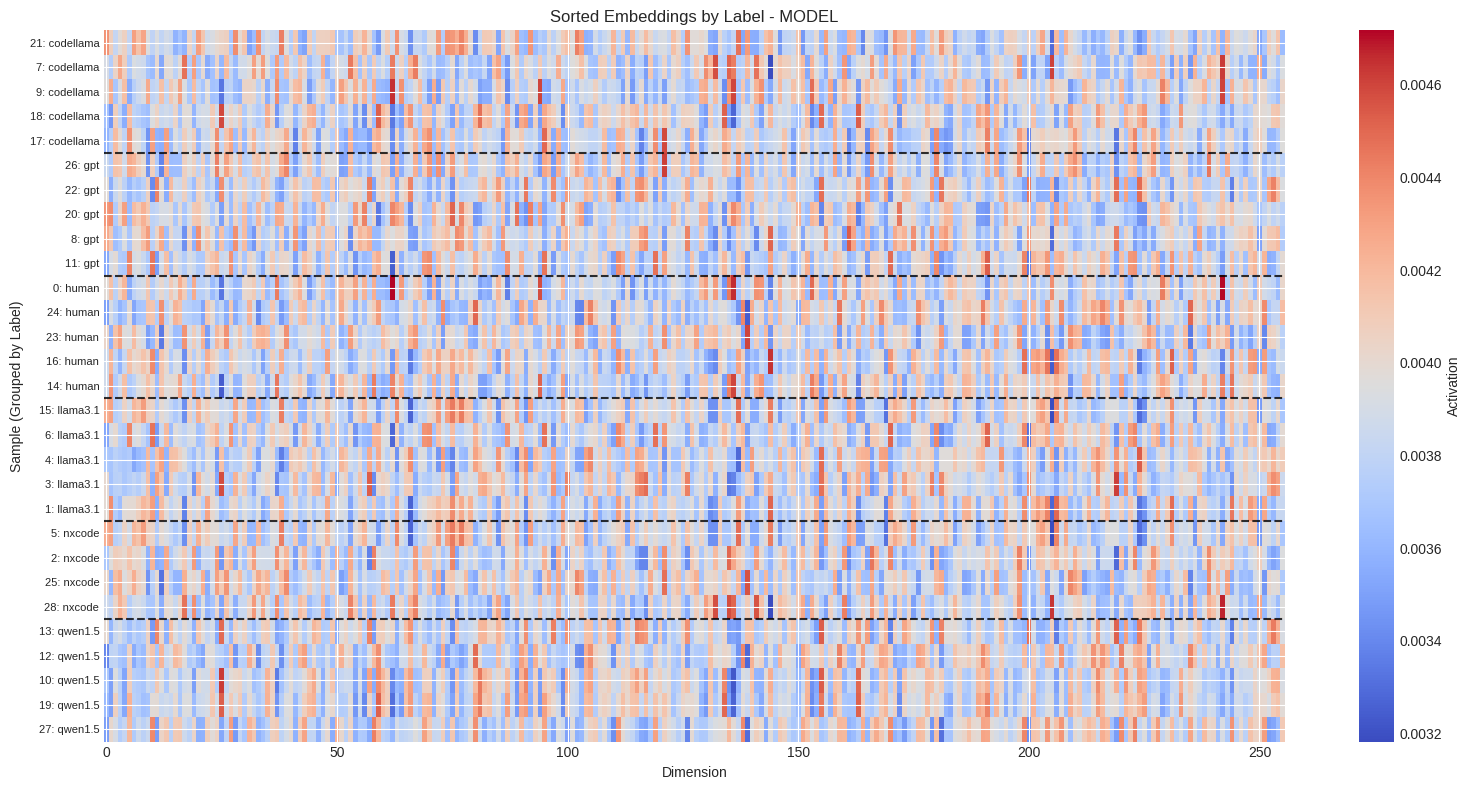

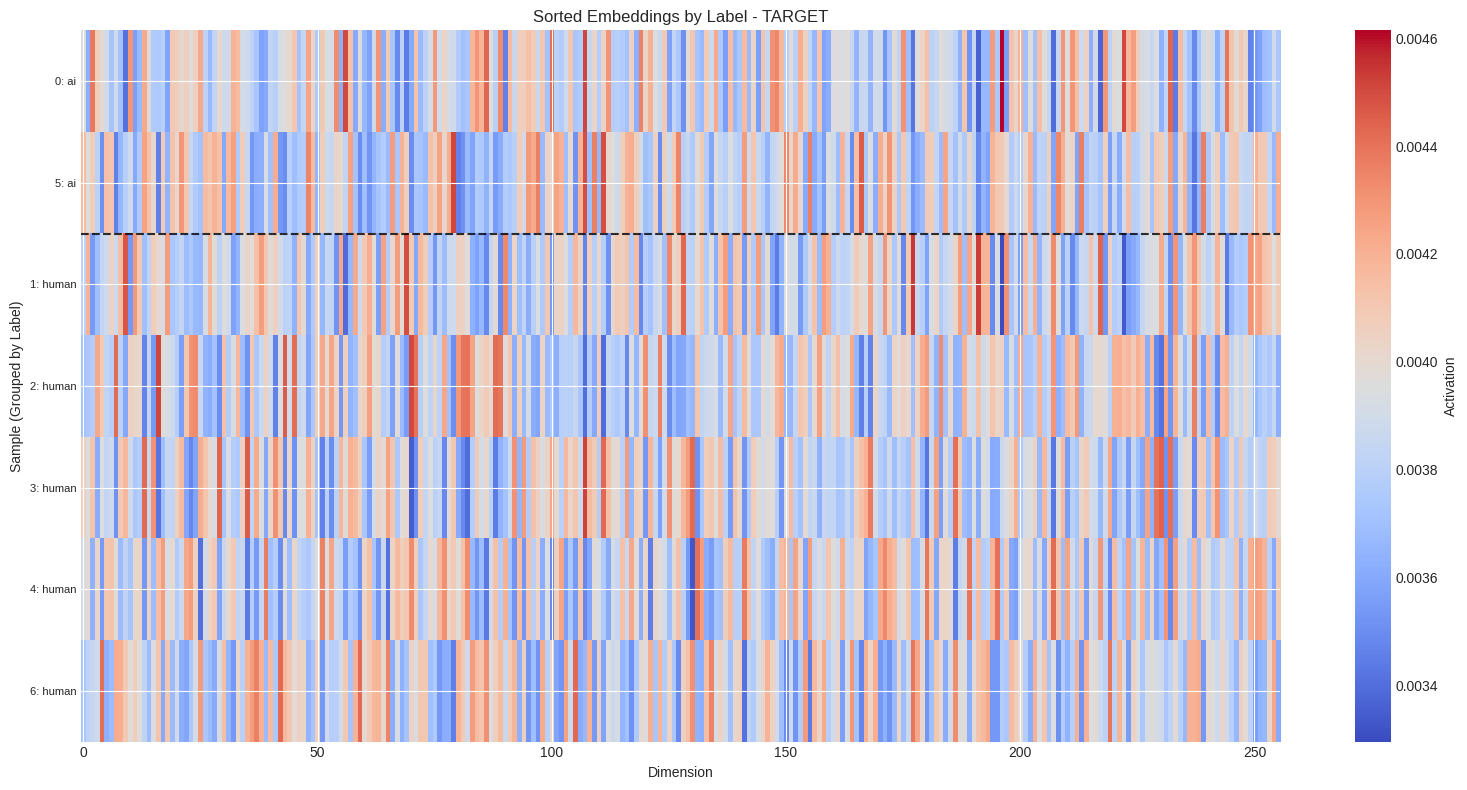

In [13]:
for label_field_val, results in experiment_results.items():
    embeddings_np = results['embeddings'].detach().cpu().numpy()
    labels_list = [data.y for data in results['pyg_dataset']]
    
    sorted_indices = np.argsort(labels_list)
    sorted_embeddings = embeddings_np[sorted_indices]
    sorted_labels = np.array(labels_list)[sorted_indices]
    
    exp_vals = np.exp(sorted_embeddings - np.max(sorted_embeddings, axis=1, keepdims=True))
    embeddings_processed = exp_vals / np.sum(exp_vals, axis=1, keepdims=True)
    
    plt.figure(figsize=(16, 8))
    img = plt.imshow(embeddings_processed, cmap='coolwarm', aspect='auto', interpolation='nearest')
    
    for i in range(1, len(sorted_labels)):
        if sorted_labels[i] != sorted_labels[i-1]:
            plt.axhline(y=i-0.5, color='black', linestyle='--', linewidth=1.5, alpha=0.8)
    
    plt.colorbar(img, label='Activation')
    plt.title(f'Sorted Embeddings by Label - {label_field_val.upper()}')
    plt.xlabel('Dimension')
    plt.ylabel('Sample (Grouped by Label)')
    plt.yticks(range(len(sorted_labels)), [f"{i}: {l}" for i, l in zip(sorted_indices, sorted_labels)], fontsize=8)
    plt.tight_layout()
    plt.show()

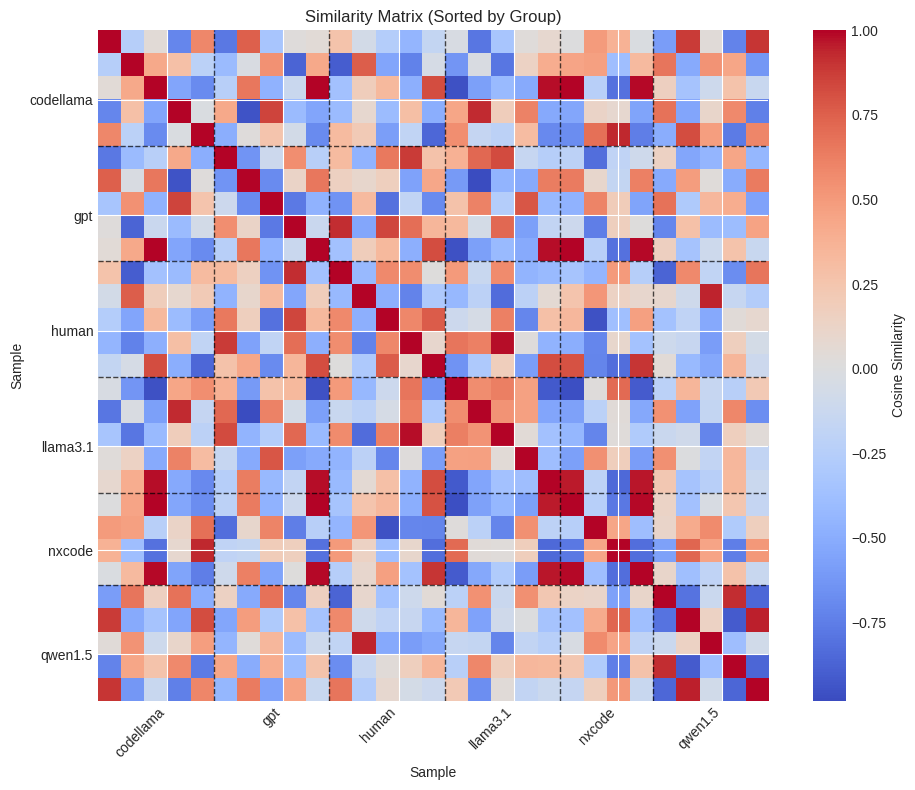

In [ ]:
for label_field_val, results in experiment_results.items():
    embeddings_np = results['embeddings'].detach().cpu().numpy()
    labels_list = [data.y for data in results['pyg_dataset']]
    
    sorted_indices = np.argsort(labels_list)
    sorted_embeddings = embeddings_np[sorted_indices]
    sorted_labels = np.array(labels_list)[sorted_indices]
    
    norms = np.linalg.norm(sorted_embeddings, axis=1, keepdims=True)
    normalized_embeddings = sorted_embeddings / (norms + 1e-8)
    similarity_matrix = np.dot(normalized_embeddings, normalized_embeddings.T)
    
    plt.figure(figsize=(10, 8))
    img = plt.imshow(similarity_matrix, cmap='coolwarm', interpolation='nearest')
    plt.colorbar(img, label='Cosine Similarity')
    
    transitions = [i for i in range(1, len(sorted_labels)) if sorted_labels[i] != sorted_labels[i-1]]
    for t in transitions:
        plt.axhline(y=t-0.5, color='black', linestyle='--', linewidth=1, alpha=0.7)
        plt.axvline(x=t-0.5, color='black', linestyle='--', linewidth=1, alpha=0.7)
    
    group_starts = [0] + transitions + [len(sorted_labels)]
    tick_locs = [(group_starts[i] + group_starts[i+1]) / 2 for i in range(len(group_starts)-1)]
    group_names = [sorted_labels[group_starts[i]] for i in range(len(group_starts)-1)]
    
    plt.title(f'Similarity Matrix - {label_field_val.upper()}')
    plt.xlabel('Sample')
    plt.ylabel('Sample')
    plt.xticks(tick_locs, group_names, rotation=45, ha='right')
    plt.yticks(tick_locs, group_names)
    plt.tight_layout()
    plt.show()

## 6. Results Analysis & Visualization

In [15]:
print("\n" + "="*80)
print("Experiment Results")
print("="*80)

print(f"\nGlobal Configuration:")
print(f"  Epochs: {num_epochs}  |  Batch: {batch_size}  |  Embedding Dim: {embedding_dim}")
print(f"  Learning Rate: {learning_rate}  |  Seed: {seed}")

print(f"\nExperiment Summary:")
print("─"*80)

for label_field_val, results in experiment_results.items():
    label_info = ", ".join([f"{label}({count})" for label, count in results['label_counts'].items()])
    
    print(f"\n{label_field_val.upper()}:")
    print(f"  Dataset: {len(results['sample_code'])} samples → {len(results['pyg_dataset'])} valid graphs")
    print(f"  Labels: {label_info}")
    print(f"  Embeddings: {results['embeddings'].shape[0]} samples × {results['embeddings'].shape[1]} dimensions")
    print(f"  Checkpoint: {results['checkpoint_path']}")

print("\n" + "="*80)
print("Experiments completed")
print("="*80)


Experiment Results

Global Configuration:
  Epochs: 100  |  Batch: 128  |  Embedding Dim: 256
  Learning Rate: 0.001  |  Seed: 42

Experiment Summary:
────────────────────────────────────────────────────────────────────────────────

MODEL:
  Dataset: 29 samples → 29 valid graphs
  Labels: codellama(5), gpt(5), human(5), llama3.1(5), nxcode(4), qwen1.5(5)
  Embeddings: 29 samples × 256 dimensions
  Checkpoint: checkpoints/CodeCLIP_model/checkpoint.pt

TARGET:
  Dataset: 7 samples → 7 valid graphs
  Labels: ai(2), human(5)
  Embeddings: 7 samples × 256 dimensions
  Checkpoint: checkpoints/CodeCLIP_target/checkpoint.pt

Experiments completed


## 7. Export & Reproducibility

In [ ]:
def export_results(results_dict, log_dict, export_dir='results'):
    """Export experiment results and metadata for reproducibility."""
    import json
    from pathlib import Path
    
    Path(export_dir).mkdir(exist_ok=True)
    
    # Save experiment log
    with open(f'{export_dir}/experiment_log.json', 'w') as f:
        log_dict['timestamp'] = str(log_dict['timestamp'])
        log_dict['device'] = str(log_dict['device'])
        json.dump(log_dict, f, indent=2)
    
    # Save results summary
    summary = {}
    for exp_name, result in results_dict.items():
        summary[exp_name] = {
            'dataset_size': len(result['sample_code']),
            'valid_graphs': len(result['pyg_dataset']),
            'embedding_shape': str(result['embeddings'].shape),
            'labels': result['unique_labels'],
            'label_counts': result['label_counts'],
            'checkpoint': result['checkpoint_path']
        }
    
    with open(f'{export_dir}/results_summary.json', 'w') as f:
        json.dump(summary, f, indent=2)
    
    print(f"Results exported to {export_dir}/")

# Uncomment to export results
# export_results(experiment_results, experiment_log)